In [6]:
# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


from rikabplotlib.plot_utils import newplot, hist_with_outline, hist_with_errors

# Data

In [7]:
N_jets = 250000
R = 0.4
X, y = qg_jets.load(N_jets)

# Jet only jets with y = 1
X = X[y == 1][:N_jets]

# Preprocess
X = X[:,:,:3]
total_energy = np.sum(X[:,:,0], axis=1)
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

angularity = np.sum(X[:,:,0] * np.sqrt(X[:,:,1]**2 + X[:,:,2]**2) , axis=1)

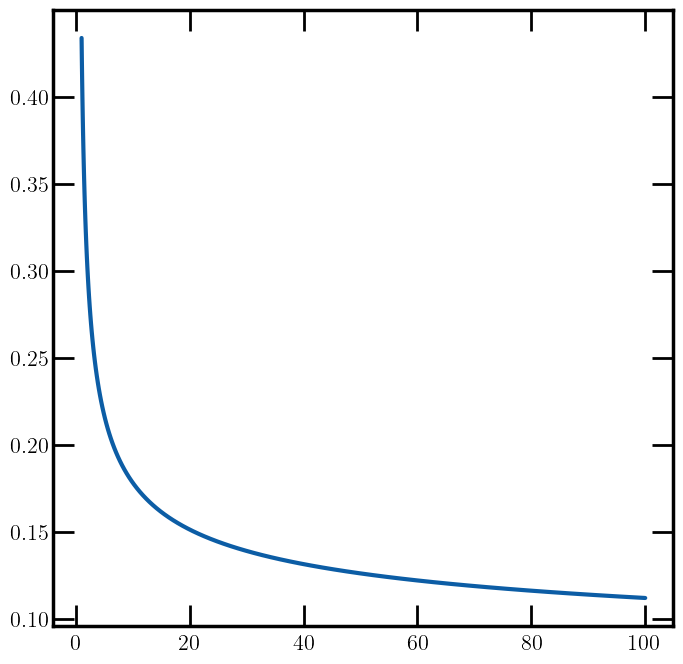

In [19]:
def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))

def angularity_function(lambda_):

    alpha_s_scale = alpha_s(lambda_ * 500)
    C_F = 4/3
    C_A = 3



    return -(alpha_s_scale * C_F / (1 * np.pi)) * np.log(lambda_ ) / lambda_

# plot alpha_s as a function of scale
lambdas = np.logspace(0, 2, 100)
alphas = np.array([alpha_s(l) for l in lambdas])
plt.plot(lambdas, alphas)


0.7428115335834232
(100,) (100,) (124905,)


/tmp/ipykernel_763785/876534230.py:52: RuntimeWarning: divide by zero encountered in true_divide
  plt.errorbar(lambdas, bins / densities , yerr = errors / densities, label="Ratio", color="black", fmt="o")
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3642: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


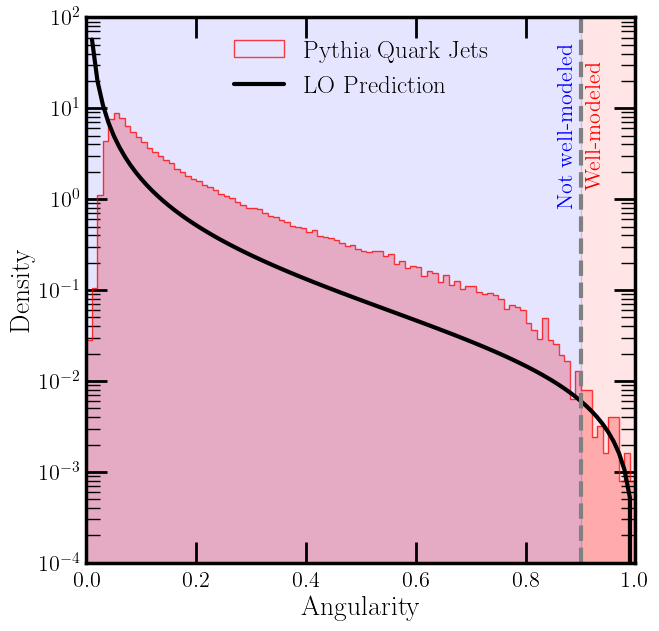

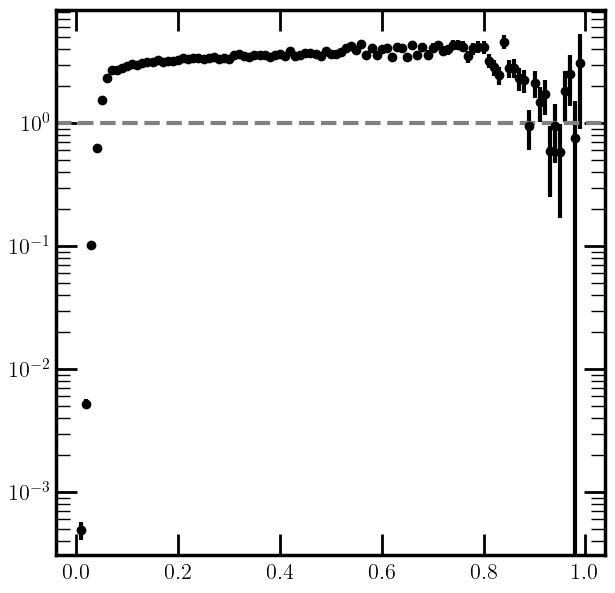

In [51]:
fig, ax = newplot("full")

normalized_angularity = angularity / np.max(angularity)
bins, edges = np.histogram(normalized_angularity, bins=100, range=(0,1))

errors = np.sqrt(bins)
total_norm = np.sum(bins) * (edges[1] - edges[0])
bins = bins / total_norm
errors = errors / total_norm 



hist_with_outline(ax, normalized_angularity, bins=100, range=(0,1),  density = True, color = "red", label = "Pythia Quark Jets")
lambdas = np.linspace(0.01, 1, 100)
densities = angularity_function(lambdas)
densities = np.maximum(0, densities)

# normalize angularities so the integral is 1
print(np.trapz(densities, lambdas))
densities = densities / np.trapz(densities, lambdas) 
ax.plot(lambdas, densities, color="black", label = "LO Prediction")


plt.xlabel("Angularity")
plt.ylabel("Density")
plt.yscale("log")


# add verticle line at 0.8
plt.axvline(0.9, color="grey", linestyle="--")

# to the left of 0.8, fill in the area
ax.fill_betweenx([0, 100], 0, 0.9, color="blue", alpha=0.1)
plt.text(0.875, 0.8, "Not well-modeled", color="blue", transform=ax.transAxes, rotation=90, va="center", ha="center")

# to the right of 0.8, fill in the area
ax.fill_betweenx([0, 100], 0.9, 1, color="red", alpha=0.1)
plt.text(0.925, 0.8, "Well-modeled", color="red", transform=ax.transAxes, rotation=90, va="center", ha="center")


plt.ylim(1e-4, 1e2)
plt.xlim(0, 1)
plt.legend(frameon=False, loc="upper center")

plt.savefig("angularity_prediction.pdf", bbox_inches="tight")

fig, ax = newplot("full")

# ratio
print(lambdas.shape, densities.shape, normalized_angularity.shape)

plt.errorbar(lambdas, bins / densities , yerr = errors / densities, label="Ratio", color="black", fmt="o")

# line at 1
plt.axhline(1, color="grey", linestyle="--")
plt.yscale("log")


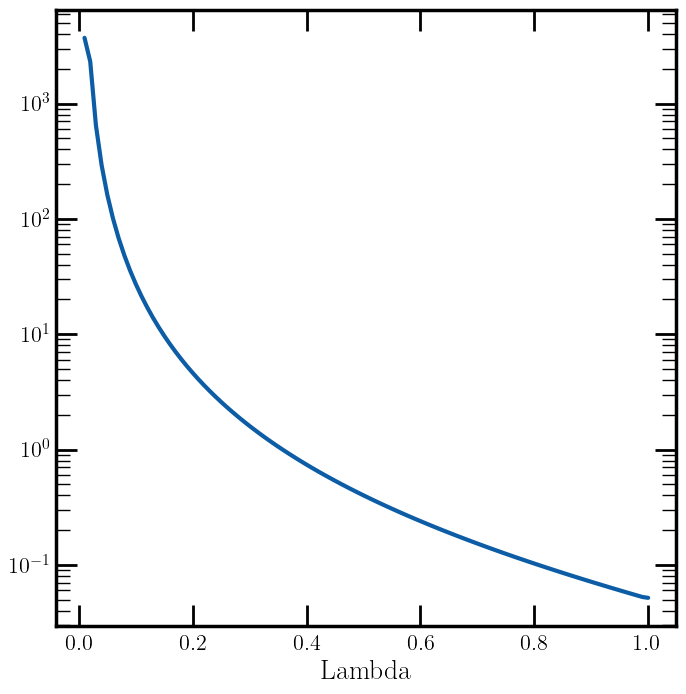

In [53]:
# Plot the slope of densities
plt.xlabel("Lambda")
derivative = np.gradient(densities, lambdas)
plt.plot(lambdas, -derivative / alpha_s(500 * lambdas) / (4 / 3) * np.pi, label="Derivative of Prediction")
plt.yscale("log")